In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import numpy as np
import beadpy
import pandas as pd

In [483]:
%matplotlib notebook

In [664]:
def trajectory_simulator(pre_duration = 250, #Mean event start time
                         pre_sigma = 50, #Sigma of event start time distribution
                         post_duration = 250, #The bead stays on for this long at the end of the trajectory
                         mean_duration = 100, #Mean event duration
                         min_duration = 10, #Minimum event duration
                         mean_rate = 500, #Mean rate (distance units/timestep)
                         rate_sigma = 50, #Sigma of the rate distribution
                         noise_sigma = 500, #Mean sigma for the bead movement
                         noise_sigma_sigma = 100, #Sigma of the noise sigma distribution
                         pause_prob = 0.001, #Probability of entering a pause in a given timestep
                         pause_duration_prob = 0.2, #Probability of remaining paused in a given timestep once a pause has begun.
                         rate_change_prob = 0.1, #Probablity that the rate will change in a given timestep
                         DNA_length = 15000, #Length of the DNA - a hard limit on the event length
                         trajectory_number = 0):
    length = int(np.random.exponential(mean_duration)) #Length is drawn from an exponential distribution.
    while length < min_duration:
        length = int(np.random.exponential(mean_duration)) #The length should be at least a certain value.
        
    current_rate = 0
    pre = int(np.random.normal(loc=pre_duration, scale = pre_sigma))
    post = post_duration
    rate = 0
    ratesequence = [0]*pre
    noise_sigmaval = int(np.random.normal(loc=noise_sigma, scale = noise_sigma_sigma))
    position = [0]*pre
    nucleotides = []
    current_position = 0
    for i in range(0,pre):
        nucleotides.append(float(position[i]+np.random.normal(loc=0.0, scale = noise_sigmaval)))
    for i in range(0,length):
        randomnumber = random.random() #generate a random float between 0 and 1
        if i == 0: #Start the event
            rate =  np.random.normal(loc=mean_rate, scale = rate_sigma)            
        elif not rate == 0: #When during an event/no pause.
            if (randomnumber <= pause_prob): #Start a pause.
                rate = 0
            elif (randomnumber > pause_prob) & (randomnumber <= (pause_prob + rate_change_prob)): #Change the rate
                rate = np.random.normal(loc=mean_rate, scale = rate_sigma)
            else: #No rate change
                rate = rate #just FYI!         
        elif (rate == 0) & (not i ==0): #When in a pause.
            if (randomnumber < (1- pause_duration_prob)): #End the pause.
                rate = np.random.normal(loc=mean_rate, scale = rate_sigma)
            else:
                rate = 0 #Continue the pause.
        ratesequence.append(rate)
        current_position = current_position + rate
        position.append(current_position)
        nucleotides.append(float(current_position+np.random.normal(loc=0.0, scale = noise_sigmaval)))
        if current_position > DNA_length:
            length = i
            break
    for i in range(0,post):
        ratesequence.append(0)
        position.append(current_position)
        nucleotides.append(float(current_position+np.random.normal(loc=0.0, scale = noise_sigmaval)))
    time = range(0,len(nucleotides))
    results = pd.DataFrame({'time' : time,
                        'nucleotides' : nucleotides,
                           'rate' : ratesequence,
                           'position' : position})
    results['trajectory'] = trajectory_number
    return results

<IPython.core.display.Javascript object>


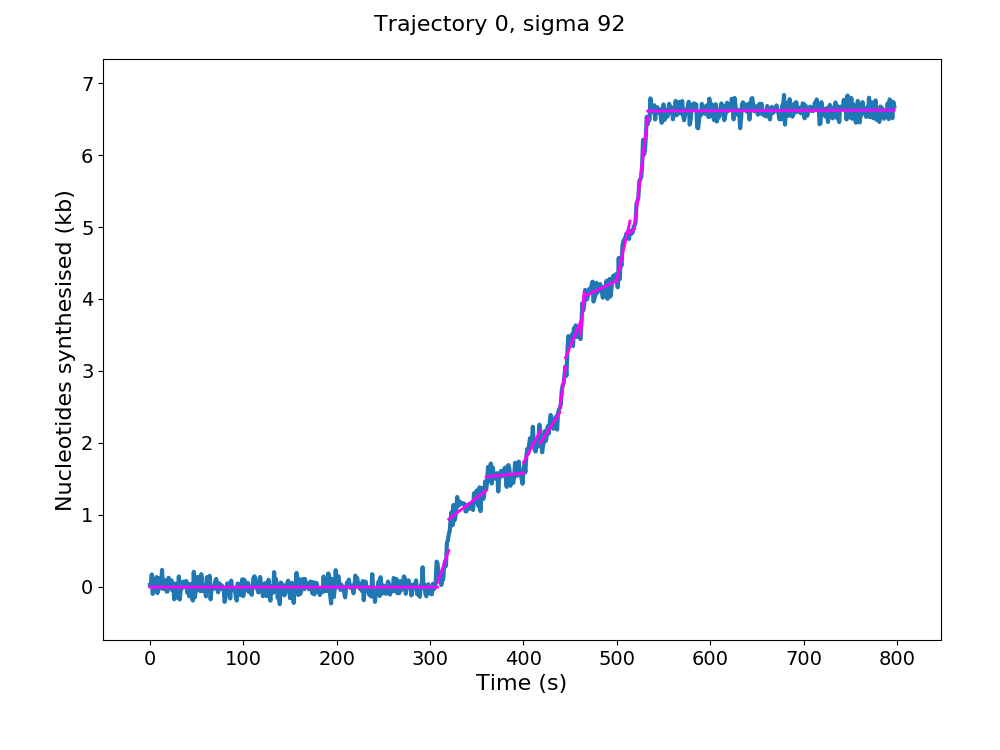

In [733]:
test = trajectory_simulator(pre_duration = 300,
                         pre_sigma = 5,
                         post_duration = 250, 
                         mean_duration = 100,
                         min_duration = 10,
                         mean_rate = 80,
                         rate_sigma = 30,
                         noise_sigma = 100,
                         noise_sigma_sigma = 20,
                         pause_prob = 0.1,
                         pause_duration_prob = 0.9,
                         rate_change_prob = 0.01,
                         DNA_length = 15000,
                         trajectory_number = 0)
exampletrajseg = beadpy.trajectory_plotter(test, 0, method = ('auto', 'whole'), 
                                           sigma_start = 10, sigma_end = 250,  
                                           eventregion = (200,500), 
                                           segmenttable = 0)

In [734]:
exampletrajseg

,rate,intercept,x1,x2,y1,y2,displacement,duration,trajectory
0,0.0,-7.0,0.0,308.0,-7.0,-7.1,-0.1,308.0,0.0
1,36.9,-11310.0,308.0,320.0,59.8,502.7,443.0,12.0,0.0
2,9.9,-2234.0,320.0,360.0,938.2,1334.7,396.5,40.0,0.0
3,1.3,1041.0,360.0,400.0,1525.0,1578.8,53.8,40.0,0.0
4,24.3,-7998.0,400.0,418.0,1725.7,2163.3,437.6,18.0,0.0
5,20.4,-6515.0,418.0,439.0,1994.7,2422.3,427.5,21.0,0.0
6,93.9,-38750.0,439.0,445.0,2486.8,3050.4,563.6,6.0,0.0
7,31.2,-10685.0,445.0,461.0,3181.9,3680.5,498.6,16.0,0.0
8,150.1,-65695.0,461.0,465.0,3488.7,4089.0,600.3,4.0,0.0
9,6.3,1119.0,465.0,500.0,4033.3,4252.6,219.3,35.0,0.0


Compare the table of actual changepoints below (ignoring rate changes of less than 10) with the above table of the discovered changepoints above.

In [735]:
changepoints = []
changepoint_values = []
duration = []
for i in test.time[1:]:
    if abs(test.rate[i] - test.rate[i-1]) > 10:
        changepoints.append(i)
        changepoint_values.append(test.rate[i])
for i in range(0, (len(changepoints) - 1)):
    duration.append(changepoints[i+1]-changepoints[i])
duration.append(0)
cpts = pd.DataFrame({'changepoint' : changepoints,
                    'rate' : changepoint_values,
                    'duration' : duration})
cpts

,changepoint,duration,rate
0,306,3,70.277313
1,309,5,0.000000
2,314,12,76.769973
3,326,23,0.000000
4,349,1,127.439888
5,350,8,0.000000
6,358,8,39.171484
7,366,34,0.000000
8,400,7,59.906436
9,407,15,0.000000


## Simulation of a combined phi29 + E. coli experiment

Generate a large results table.

In [700]:
phi29results = pd.DataFrame()
for j in range(0,1000):
    temp = trajectory_simulator(pre_duration = 300,
                         pre_sigma = 20,
                         post_duration = 250, 
                         mean_duration = 100,
                         min_duration = 10,
                         mean_rate = 80,
                         rate_sigma = 40,
                         noise_sigma = 100,
                         noise_sigma_sigma = 20,
                         pause_prob = 0.1,
                         pause_duration_prob = 0.5,
                         rate_change_prob = 0.01,
                         DNA_length = 15000,
                         trajectory_number = j)
    phi29results = phi29results.append(temp)

In [699]:
coliresults = pd.DataFrame()
for j in range(1001,2000):
    temp = trajectory_simulator(pre_duration = 300,
                         pre_sigma = 20,
                         post_duration = 250, 
                         mean_duration = 150,
                         min_duration = 10,
                         mean_rate = 442,
                         rate_sigma = 198,
                         noise_sigma = 100,
                         noise_sigma_sigma = 20,
                         pause_prob = 0.1,
                         pause_duration_prob = 0.7,
                         rate_change_prob = 0.05,
                         DNA_length = 15000,
                         trajectory_number = j)
    coliresults = coliresults.append(temp)

In [701]:
results = pd.concat([phi29results,coliresults])

In [702]:
combosegments = beadpy.segment_finder(results, method = 'auto', sigma_start=10, sigma_end=200)

<IPython.core.display.Javascript object>


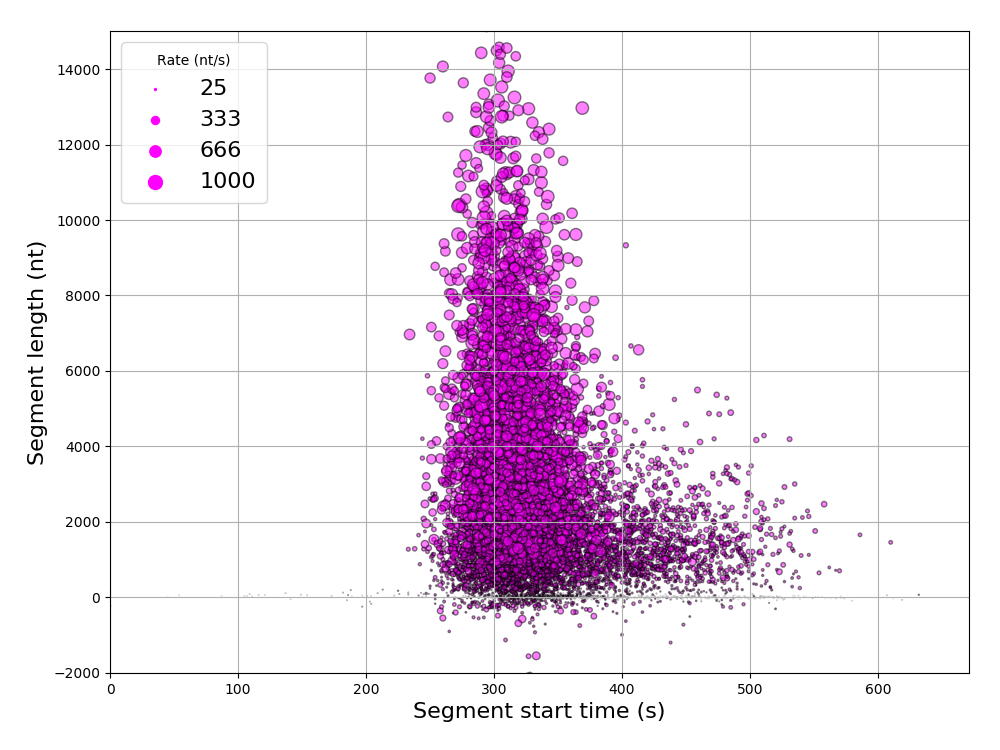

In [703]:
beadpy.segmentplotter(combosegments,1000,-2000,15000, 2, 10)

<IPython.core.display.Javascript object>


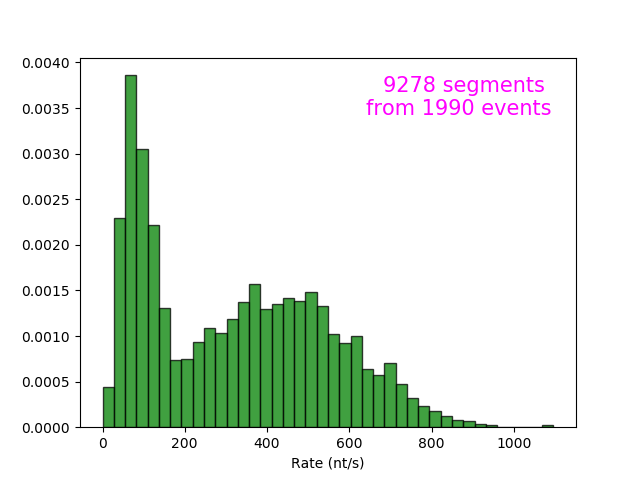

In [719]:
beadpy.ratehist(combosegments,0, 1100, 40, 'displacement')